### 集成算法
[推荐阅读 集成算法](www://,l-ensemble.com)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df = pd.read_csv('./input.csv')


# 获取训练数据
def get_train_test(test_size=0.95):
    '''Split Data into train and test sets'''
    y = 1 *(df.cand_pty_affiliation == 'REP')
    X = df.drop(['cand_pty_affiliation'], axis=1)
    #  onehot
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    
    return train_test_split(X, y, test_size=test_size, random_state=seed)

xtrain, xtest, y_train, y_test = get_train_test()


print("\n Example data:")
df.head()



 Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [2]:
xtrain.head()

,cycle,transaction_amt,cand_office_st_AK,cand_office_st_AL,cand_office_st_AR,cand_office_st_AZ,cand_office_st_CA,cand_office_st_CO,cand_office_st_CT,cand_office_st_DC,...,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_ZZ,classification_Engineer,classification_Math-Stat,classification_Scientist
56233,2016.0,10.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
99016,2008.0,1000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
87796,2016.0,7.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
44516,2016.0,10.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
66025,2012.0,250.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


* cand_pty_affiliation：我们要预测的指标，共和党或者民主党
* entity_tp：个人还是组织
* classification:领域
* rpt_tp：贡献的大小
* cycle：捐赠在哪年
* transaction_amt：捐献金额

### ROC 和AOU

<img src='11.png'>

<img src='10.png'>

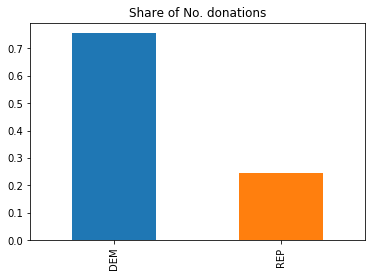

In [3]:
# labels的类别比例大小
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind='bar', title='Share of No. donations')
plt.show()

构建几个基本的决策树模型来看看

In [4]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [5]:
def print_graph(clf, features):
    graph = export_graphviz(
        clf,
        label='root',
        proportion=True,
        impurity=False,
        out_file=None,
        feature_names=features,
        class_names={0:'D',1:'R'},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

Decision tree ROC-AUC score: 0.673


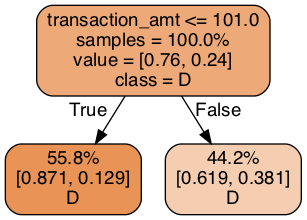

In [6]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=seed)
t1.fit(xtrain,y_train)
p = t1.predict_proba(xtest)[:,1]

print("Decision tree ROC-AUC score: %.3f"%roc_auc_score(y_test, p))
print_graph(t1, xtrain.columns)

改变树的深度试试

3 layer decision tree auc sore 0.772


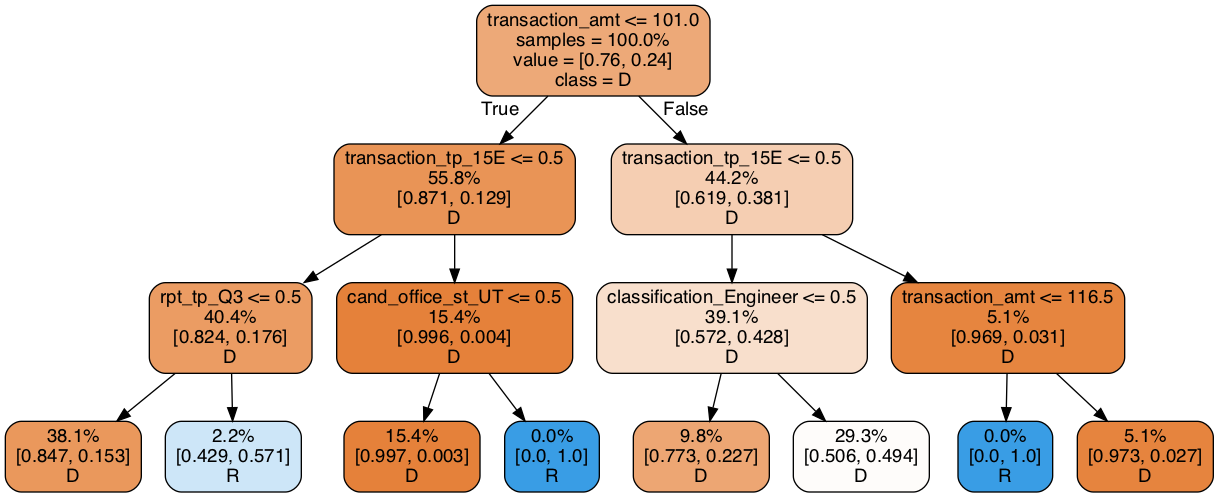

In [7]:
t2 = DecisionTreeClassifier(max_depth=3,random_state=seed)
t2.fit(xtrain,y_train)
p2 = t2.predict_proba(xtest)[:,1]

auc_score = roc_auc_score(y_test, p2)
print("3 layer decision tree auc sore %.3f"% auc_score)
print_graph(t2,xtrain.columns)

比单层的决策树auc分数要高一点了

去掉对结果影响最大的特征再试试

t3 auc socre: 0.772


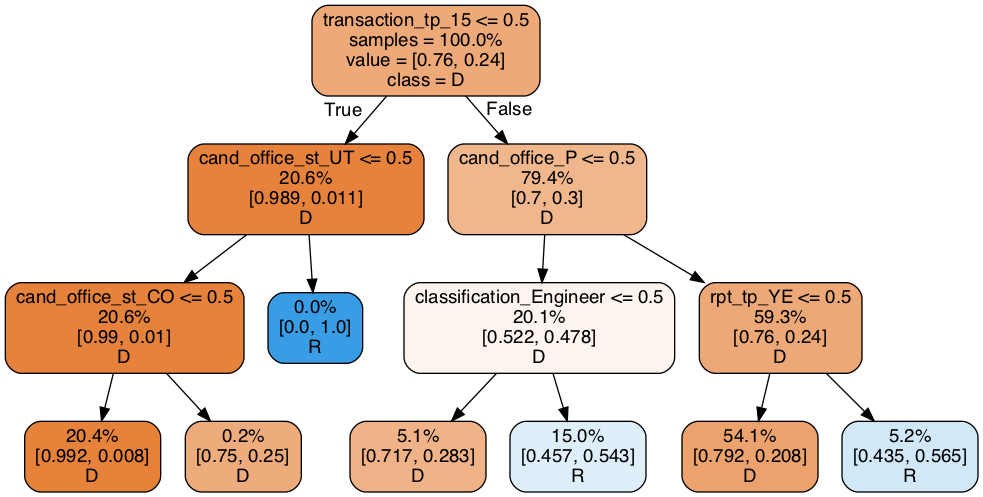

In [8]:
drop = ['transaction_amt']
xtrain_slim = xtrain.drop(drop,1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3,random_state=seed)
t3.fit(xtrain_slim,y_train)
p = t3.predict_proba(xtest_slim)[:,1]

auc_socre = roc_auc_score(y_test, p)
print('t3 auc socre: %.3f' % auc_score)
print_graph(t3, xtrain_slim.columns)

In [9]:
# 综合一下 t2 和t3 
p1 = t2.predict_proba(xtest)[:,1]
p2 = t3.predict_proba(xtest_slim)[:,1]

p = np.mean([p1,p2],axis=0)

print("average of dcTree ROC-AUC socre: %.3f" % roc_auc_score(y_test,p))

average of dcTree ROC-AUC socre: 0.809


以上只是两个决策树的组合
如果有更多个的决策树参与这个过程，就是随机森林了

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=seed
)

rf.fit(xtrain,y_train)
p = rf.predict_proba(xtest)[:,1]

print("RF roc-auc score is: %.3f" % roc_auc_score(y_test,p))

RF roc-auc score is: 0.847


以上结果可以看到 随机森林的分类效果比两颗决策树的组合要强

---
### 如果使用 stacking呢

In [11]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [12]:
def get_models():
    nb = GaussianNB()
    svc = SVC(C=100,probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100,random_state=seed)
    nn = MLPClassifier((80,10),early_stopping=False, random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=seed)
    rf = RandomForestClassifier(n_estimators=10, max_features=3,random_state=seed)
    
    models = {'svm':svc, 'knn':knn, 'naive bayes':nb, 'mlp-nn':nn, 'gbm':gb, 'random forest':rf, 'logistic':lr}
    
    return models

In [13]:
def train_predict(model_list):
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    print('Fitting models')
    cols = list()
    for i, (name, model) in enumerate(model_list.items()):
        print("%s..." % name, end=" ", flush=False)
        model.fit(xtrain,y_train)
        p = model.predict_proba(xtest)[:,1]
        P.iloc[:,i] = p
        cols.append(name)
        print('done')
    
    P.columns = cols
    print('\n Done. \n')
    return P

In [14]:
def score_auc(P, y):
    print(' Scoring models\n')
    for name in P.columns:
        auc_score = roc_auc_score(y, P.loc[:,name])
        print('%-26s auc_score is %.3f' % (name, auc_score))
    
    print('Score Done\n')

In [15]:
models = get_models()
P = train_predict(models)

Fitting models
svm... 

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
knn... done
naive bayes... done
mlp-nn... done
gbm... done
random forest... done
logistic... done

 Done. 



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
score_auc(P,y_test)

 Scoring models

svm                        auc_score is 0.839
knn                        auc_score is 0.781
naive bayes                auc_score is 0.805
mlp-nn                     auc_score is 0.868
gbm                        auc_score is 0.878
random forest              auc_score is 0.847
logistic                   auc_score is 0.853
Score Done



In [17]:
print('ensemble roc-auc score: %.3f' %roc_auc_score(y_test, P.mean(axis=1)))

ensemble roc-auc score: 0.885


仅仅是将所有的分类器的结果再取平均，就能取得更高的auc分数

In [18]:
P.head()

,svm,knn,naive bayes,mlp-nn,gbm,random forest,logistic
0,0.059982,0.000000,2.044948e-21,0.026807,0.093102,0.0,0.040943
1,0.024971,0.000000,4.032610e-59,0.006615,0.041729,0.0,0.001673
2,0.020740,0.000000,1.824972e-68,0.003341,0.017288,0.0,0.003246
3,0.467514,0.333333,1.000000e+00,0.311846,0.595783,0.2,0.742305
4,0.170486,0.000000,7.187294e-28,0.034258,0.129894,0.0,0.043366


In [20]:
from sklearn.metrics import roc_curve
# fpr, tpr,_ = roc_curve(y_test, p)

def plot_auc_curve(y_test, P):
    labels = P.columns
    base_models_p = P.values
    
    ensemble_p = P.mean(axis=1)
    ensemble_label = 'ensemble'
    
    fig = plt.figure(figsize=(10,8))
    plt.plot([0,0],[1,1],'k--')
    
    cm = [plt.cm.rainbow(i) for i in np.linspace(0,1.0, base_models_p.shape[1]+1)]
    
    for i in range(base_models_p.shape[1]):
        p = base_models_p[:,i]
        fpr, tpr, _ = roc_curve(y_test, p)
        plt.plot(fpr, tpr, label=labels[i] , c=cm[i+1])
    
    fpr, tpr, _ = roc_curve(y_test, ensemble_p)
    plt.plot(fpr, tpr, label=ensemble_label, c=cm[0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.title('AUC - curve')
    plt.legend()
    plt.show()

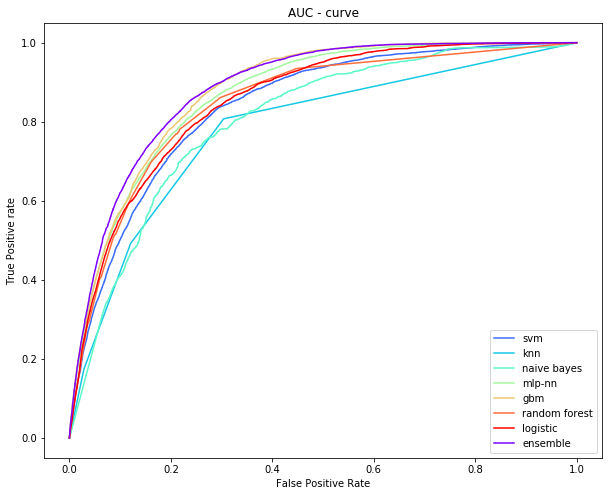

In [21]:

plot_auc_curve(y_test, P)

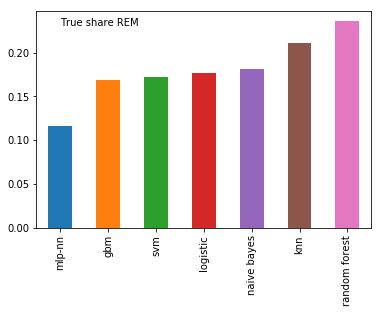

In [31]:
# 查看各个分类器预测出来的label比例
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ['DEM','REP']
p.loc['REP',:].sort_values().plot(kind='bar')
plt.text(0,0.23,'True share REM')
plt.show()

可以看到 mlp-nn的分类器预测效果 跟实际的比例差距较大

In [32]:
include = [x for x in P.columns if x not in ['mlp-nn']]
print(include)

['svm', 'knn', 'naive bayes', 'gbm', 'random forest', 'logistic']


In [34]:
print('without mlp-nn ensemble auc score:',roc_auc_score(y_test, P.loc[:,include].mean(axis=1)))

without mlp-nn auc score: 0.8831621026426943


再次想到，这些分类器的具有不同的分类效果，如果按照平均算肯定是牺牲了精度的。
所以我们将各个分类器的输出作为输入，构建一个带有权重的输出分类器，作为第二层的结构，来对各个分类器加权，得到更好的输出

In [35]:
# 1 定义第一次基础模型
base_leaners = get_models()

In [49]:
# 定义第二次模型
meta_leaner = GradientBoostingClassifier(
    n_estimators=100,
    loss='exponential',
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005,
    random_state=seed
)

In [41]:
# 重新分割数据集
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(xtrain,y_train, test_size=0.5, random_state=seed)

In [40]:
# 训练基础模型
def train_base_learner(models, inp, out, verbose):
    if verbose: print('Fitting models')
    for i, (name,model) in enumerate(models.items()):
        if verbose: print('%s ...' % name, end='', flush=False)
        model.fit(inp, out)
        if verbose:print('done')

In [43]:
train_base_learner(base_leaners, xtrain_base, ytrain_base,True)

Fitting models
svm ...

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


done
knn ...done
naive bayes ...done
mlp-nn ...done
gbm ...done
random forest ...done
logistic ...done


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [44]:
def predict_base_learners(base_learners, inp,verbose=True):
    P = np.zeros((inp.shape[0], len(base_leaners)))
    
    if verbose:print('predicting base models')
    for i ,(name, model) in enumerate(base_leaners.items()):
        if verbose:print('%s ...' % name, end='', flush=False)
        p = model.predict_proba(inp)[:,1]
        P[:,i] = p
        if verbose:print('done')
            
    return P
    

In [45]:
P_base = predict_base_learners(base_leaners,xpred_base)

predicting base models
svm ...done
knn ...done
naive bayes ...done
mlp-nn ...done
gbm ...done
random forest ...done
logistic ...done


In [46]:
P_base.shape

(2500, 7)

In [48]:
ypred_base.shape

(2500,)

In [50]:
# 训练第二层分类器
meta_leaner.fit(P_base,ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [51]:
# ensemble 预测
def ensemble_predict(base_leanners, meta_leanser, inp, verbose=True):
    P_pred = predict_base_learners(base_leanners,inp,verbose=verbose)
    p = meta_leaner.predict_proba(P_pred)[:,1]
    return P_pred, p

In [52]:
P_base,p = ensemble_predict(base_leaners,meta_leaner,xtest)
print("\n ensemble ROC-AUC socre: %3f"%roc_auc_score(y_test, p))

predicting base models
svm ...done
knn ...done
naive bayes ...done
mlp-nn ...done
gbm ...done
random forest ...done
logistic ...done

 ensemble ROC-AUC socre: 0.878923


### 使用mlens 的superlearner 多线程加速训练

In [54]:
# 使用 superLeaner
from mlens.ensemble import SuperLearner

In [55]:
sl = SuperLearner(
    folds=10,
    random_state=seed,
    verbose=2,
    backend='multiprocessing'
    )

In [56]:
# 添加基础模型
sl.add(list(base_leaners.values()), proba=True)
# 添加原模型
sl.add_meta(meta_leaner, proba=True)

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20, scorer=None, shuffle=False,
       verbose=2)

In [ ]:
sl.fit(xtrain,y_train)


Fitting 2 layers
Processing layer-1             

In [ ]:
p_sl = sl.predict_proba(x_test)[:,1]
print('SuperLearner Roc-auc score: %.3f'%roc_auc(y_test,p_sl))